In [1]:
import os
import sys
import shutil

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from copy import deepcopy

In [3]:
from BuildingOccupancy import BuildingOccupancyAsMatrix
from DefaultBuildings import Building_5ZoneAirCooled
from CentralController import one_single_episode
from Options import get_argparser
from SQLOutput import SQLOutput
import StateUtilities as SU

In [4]:
import visualization_helper_v2 as vh

Documentation: https://cobs-platform.github.io/

In [5]:
args = [
    '--algorithm', "baseline_rule-based",
    "--idf_file", os.path.abspath("../scripts/5ZoneAirCooled_HigherWinterSetpoint.idf"),
    "--epw_file", os.path.abspath("../../COBS/cobs/data/weathers/8.epw"),
    "--checkpoint_dir", "/tmp"
]
args = get_argparser().parse_args(args)

In [6]:
fig_width = 16

<h3>Define the model</h3>

In [7]:
cobs.Model.set_energyplus_folder(global_paths["eplus"])

In [8]:
building = Building_5ZoneAirCooled(args)

In [9]:
building_occ = BuildingOccupancyAsMatrix(args, building)

<h3>Define the agents (and the controlled devices)</h3>

In [10]:
class Agent_Rulebased():
    
    def __init__(self):
        self.type = "NoRL"
        self.class_name = "VAV with Reheat,Heating,Cooling,NoRL"

    def initialize(self, name, controlled_element,
                   temp_occu_mean   = 21.5, temp_occu_delta   = 1.0,
                   temp_unoccu_mean = 23.0, temp_unoccu_delta = 7.0,
                   vav_pos_occu = 1.0, vav_pos_unoccu = 0.3):
        self.name = name
        self.controlled_element = controlled_element
        self.temp_occu_mean  = temp_occu_mean
        self.temp_occu_delta = temp_occu_delta
        self.temp_unoccu_mean    = temp_unoccu_mean
        self.temp_unoccu_delta   = temp_unoccu_delta
        self.vav_pos_occu   = vav_pos_occu
        self.vav_pos_unoccu = vav_pos_unoccu

    def step(self, current_state):
        output_dic = {}
        # rule based setting of the heating/cooling setpoint and delta
        #  Mo - Fr, 7.00 - 18.00 h: 21.5 deg C, Delta 1 deg C
        if current_state["time"].weekday() <= 4 and \
           current_state["time"].hour >= 7 and current_state["time"].hour <= 18:
            output_dic["Zone Heating/Cooling-Mean Setpoint"]  = self.temp_occu_mean
            output_dic["Zone Heating/Cooling-Delta Setpoint"] = self.temp_occu_delta
            output_dic["Zone VAV Reheat Damper Position"] = self.vav_pos_occu
        else:
            output_dic["Zone Heating/Cooling-Mean Setpoint"]  = self.temp_unoccu_mean
            output_dic["Zone Heating/Cooling-Delta Setpoint"] = self.temp_unoccu_delta
            output_dic["Zone VAV Reheat Damper Position"] = self.vav_pos_unoccu
        return output_dic

In [11]:
agents = []
# HINT: a device can be a zone, too
for agent_name, (controlled_device, controlled_device_type) in building.agent_device_pairing.items():
    new_agent = Agent_Rulebased()
    new_agent.initialize(name = agent_name, controlled_element = controlled_device)
    agents.append(new_agent)

<h3>Set model parameters</h3>

In [12]:
#model.set_runperiod(365, 2020, 1, 1)
building.model.set_runperiod(8, 2020, 1, 1)
##building.model.set_runperiod(12, 2020, 7, 1)
#model.set_runperiod(30, 1915, 12, 12, specify_year=True)

In [13]:
building.model.set_timestep(1)   # 60 Min interval,  1 steps per hour
#building.model.set_timestep(12) #  5 Min interval, 12 steps per hour
ts_diff_in_min = 60

<h3>Run the simulation(s)</h3>

In [14]:
dirnames = []
last_available_eval_episodes = []

In [15]:
def run_one_step(checkpoint_dir):
    args.checkpoint_dir = checkpoint_dir
    sqlpath = os.path.join(args.checkpoint_dir, "ouputs.sqlite")
    if os.path.isdir(args.checkpoint_dir):
        shutil.rmtree(args.checkpoint_dir)
    os.makedirs(args.checkpoint_dir)
    sqloutput = SQLOutput(sqlpath, building)
    sqloutput.initialize()
    dirnames.append( args.checkpoint_dir )
    last_available_eval_episodes.append(0)

    status_output_dict = one_single_episode(
                        algorithm      = "baseline_rule-based",
                        building       = building,
                        building_occ   = building_occ,
                        agents         = agents,
                        critics        = [],
                        hyper_params   = args,
                        episode_number = 0,
                        sqloutput      = sqloutput,
                        extended_logging   = True,
                        evaluation_episode = True,
                        ts_diff_in_min = ts_diff_in_min)

    sqloutput.add_last_step_of_episode( status_output_dict )
    sqloutput.db.commit()
    sqloutput.db.close()

<h5>Simulation 1: VAV Damper opened, if presence hours, else closed</h5>

In [16]:
run_one_step("/tmp/livedemo-01")

<h5>Simulation 2: VAV Damper always opened</h5>

In [17]:
for agent in agents:
    agent.vav_pos_unoccu = 1.0

In [18]:
run_one_step("/tmp/livedemo-02")

<h5>Simulation 3: VAV Damper half opened, if presence hours, else closed</h5>

In [19]:
#for agent in agents:
#    agent.vav_pos_occu   = 0.5
#    agent.vav_pos_unoccu = 0.15

In [20]:
#run_one_step("/tmp/livedemo-03")

<h5>Simulation 3: As simulation 1, but no heating in SPACE-5, closed VAV damper in SPACE-5, without people in SPACE-5</h5>

In [21]:
for agent in agents:
    if agent.controlled_element == "SPACE5-1":
        agent.vav_pos_occu   = 0.3
        agent.vav_pos_unoccu = 0.3
        agent.temp_occu_mean = 23.0
        agent.temp_occu_delta= 7.0
    else:
        agent.vav_pos_occu   = 1.0
        agent.vav_pos_unoccu = 0.3

In [22]:
hist_occ_schedule_table = building_occ.schedule_table.copy()
building_occ.schedule_table[:,:,4] = 0

In [23]:
run_one_step("/tmp/livedemo-03")

<h5>Simulation 4: As simulation 1, but no heating in SPACE-2, rulebased VAV damper in SPACE-2, without people in SPACE-2</h5>

In [24]:
for agent in agents:
    if agent.controlled_element == "SPACE2-1":
        agent.vav_pos_occu   = 1.0
        agent.vav_pos_unoccu = 0.3
        agent.temp_occu_mean = 23.0
        agent.temp_occu_delta= 7.0
    else:
        agent.vav_pos_occu   = 1.0
        agent.vav_pos_unoccu = 0.3
        agent.temp_occu_mean = 21.5
        agent.temp_occu_delta= 1.0

In [25]:
building_occ.schedule_table = hist_occ_schedule_table

In [26]:
run_one_step("/tmp/livedemo-04")

<h5>Simulation 5: As simulation 1, but no heating in SPACE-2, closed VAV damper in SPACE-2, without people in SPACE-2</h5>

In [27]:
for agent in agents:
    if agent.controlled_element == "SPACE2-1":
        agent.vav_pos_occu   = 0.3
        agent.vav_pos_unoccu = 0.3
        agent.temp_occu_mean = 23.0
        agent.temp_occu_delta= 7.0
    else:
        agent.vav_pos_occu   = 1.0
        agent.vav_pos_unoccu = 0.3
        agent.temp_occu_mean = 21.5
        agent.temp_occu_delta= 1.0

In [28]:
run_one_step("/tmp/livedemo-05")

<h3>Evaluate the simulation</h3>

In [29]:
alldfs = [ vh.convert_sqlite_to_df(dirname) for dirname in dirnames ]

Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.


In [30]:
if not "selected_episodes" in locals().keys():
    selected_episodes = last_available_eval_episodes.copy()
if not "selected_weeks" in locals().keys():
    # the start of the evaluation episode
    selected_weeks = [datetime.datetime.strptime(dfs['sees'].iloc[0]["datetime"], "%Y-%m-%d %H:%M:%S")
                      for dfs in alldfs]

subdfs = vh.select_week_and_episode_for_dfs_list(alldfs, selected_episodes, selected_weeks)

In [31]:
vh.print_reward_informations(subdfs, selected_episodes)

First complete week of evaluation episode
For episode     0: Energy consumption:    8182.33 kWh; Numer of setpoint changes: 163.25661659761394
For episode     0: Energy consumption:    9124.97 kWh; Numer of setpoint changes: 166.89741240475465
For episode     0: Energy consumption:    7878.29 kWh; Numer of setpoint changes: 139.91099156889805
For episode     0: Energy consumption:    7726.82 kWh; Numer of setpoint changes: 212.21883755599256
For episode     0: Energy consumption:    7719.26 kWh; Numer of setpoint changes: 199.2764336497983

Mean values for episode ...
...     0: Reward: -43.01039 kWh; Setpoint change magnit.:  0.85475; Energy cons.: 42839.43819
...     0: Reward: -47.94945 kWh; Setpoint change magnit.:  0.87381; Energy cons.: 47774.68891
...     0: Reward: -41.39412 kWh; Setpoint change magnit.:  0.73252; Energy cons.: 41247.61546
...     0: Reward: -40.67675 kWh; Setpoint change magnit.:  1.11109; Energy cons.: 40454.53246
...     0: Reward: -40.62364 kWh; Setpoint ch

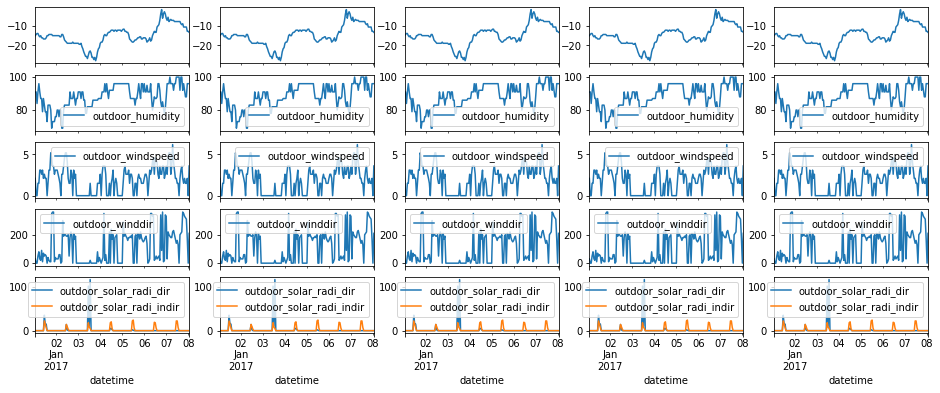

In [32]:
p, _ = vh.complete_plot_weather_information(subdfs, fig_width)
p.show()

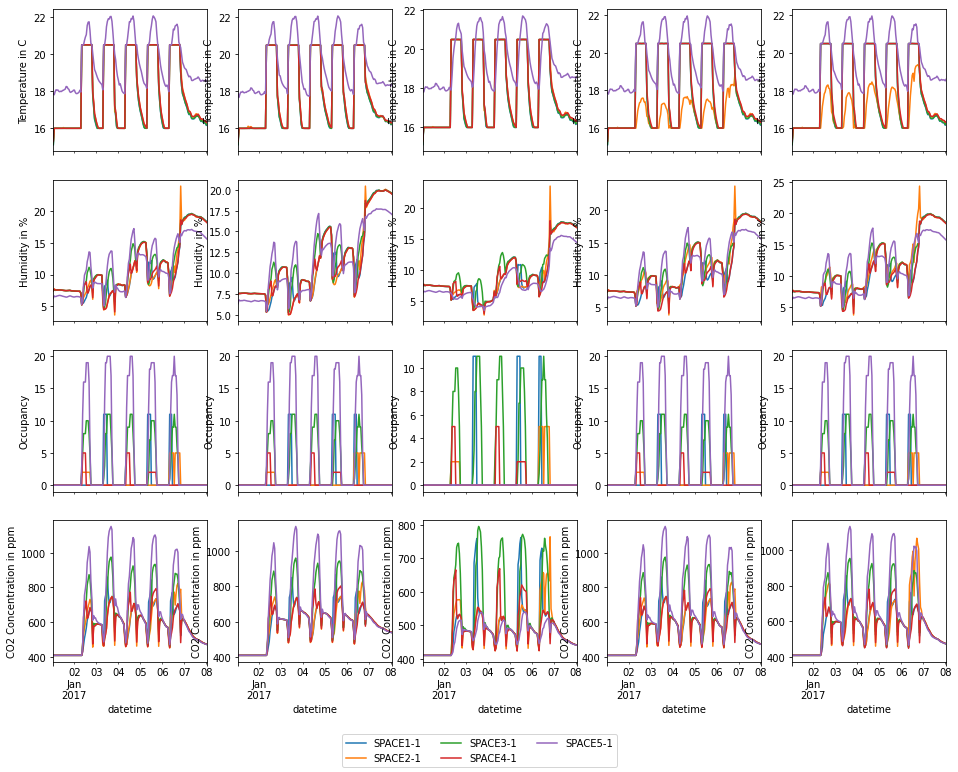

In [33]:
p, _ = vh.complete_plot_room_status(subdfs, fig_width)
p.show()

In [34]:
subdfs_rooms, subdfs_agents = vh.get_available_rooms_and_agents(subdfs)

Available Rooms     in (sub-)dfs0: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs0: {'SPACE1-1': 0, 'SPACE2-1': 1, 'SPACE3-1': 2, 'SPACE4-1': 3, 'SPACE5-1': 4} 

Available Rooms     in (sub-)dfs1: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs1: {'SPACE1-1': 0, 'SPACE2-1': 1, 'SPACE3-1': 2, 'SPACE4-1': 3, 'SPACE5-1': 4} 

Available Rooms     in (sub-)dfs2: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs2: {'SPACE1-1': 0, 'SPACE2-1': 1, 'SPACE3-1': 2, 'SPACE4-1': 3, 'SPACE5-1': 4} 

Available Rooms     in (sub-)dfs3: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs3: {'SPACE1-1': 0, 'SPACE2-1': 1, 'SPACE3-1': 2, 'SPACE4-1': 3, 'SPACE5-1': 4} 

Available Rooms     in (sub-)dfs4: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs4: {'SPACE1-1': 0, 'SPACE2-1': 1, 'SPACE3-1': 2, 'SPACE4

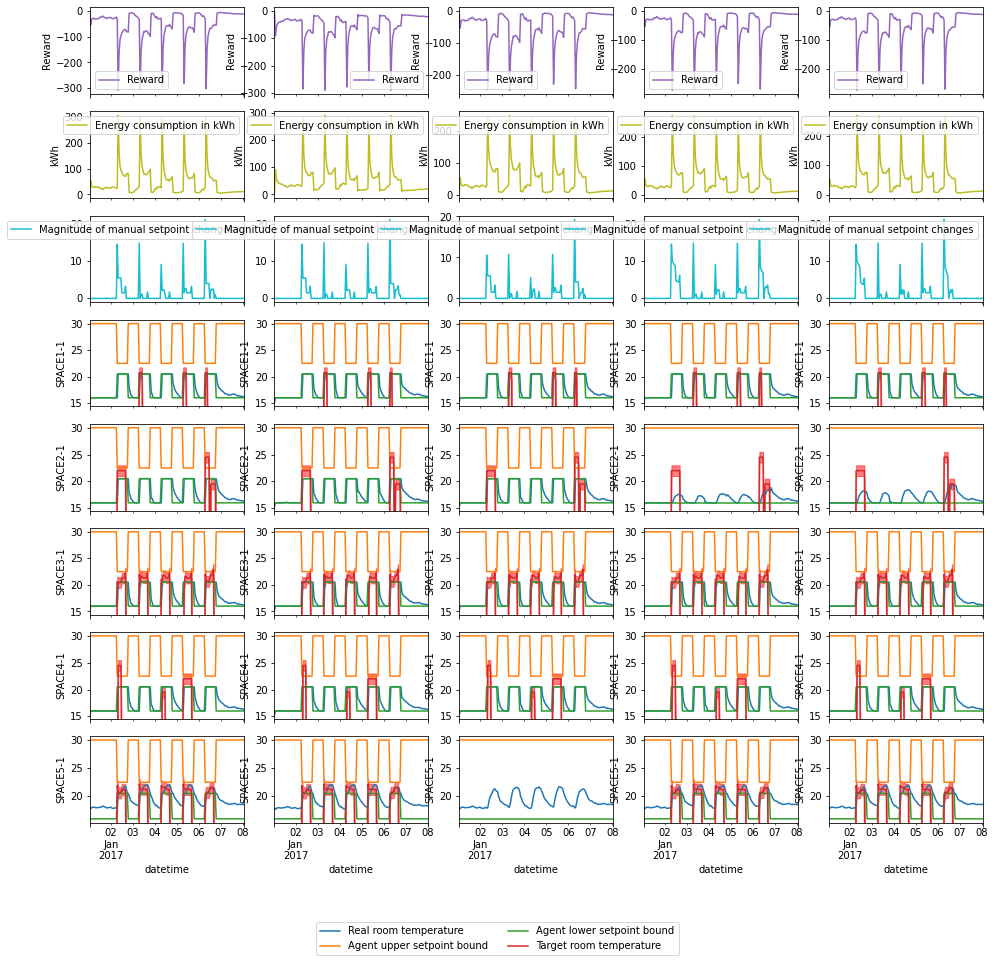

In [35]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()